<a href="https://colab.research.google.com/github/TheRamenGuy/Semantic_Segmentation_Using_U-Net/blob/main/Patches_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#We will be implementing the semantic segmentation of the dataset by following the given steps -

## 1.  Division of the images into patches
## 2. Resizing the images to a smaller dimension
## 3.  Creating the model by implementing a pre-trained resnet model (Resnet34) to set up inital weights for the U-Net model
## 4.  Predictions and visualization of the generated masks

## **1. Installing and importing necessary libraries**


In [ ]:
pip install patchify

In [ ]:
pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
import os as os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## **2. Data loading and manipulation**

In [ ]:
#creating a patch size
patch_size = 1000

In [ ]:
def patched_data_load(folder_dir, patch_size):
    image_dataset = []
    scaler = MinMaxScaler()
    random.seed(a=42)

    all_files = sorted(os.listdir(folder_dir))
    for images in tqdm(random.sample(all_files, 80)):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = np.array(image)
        print("Now patchifying image number:", folder_dir+"/"+images)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                 single_patch_img = patches_img[i,j,:,:]
                 single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds, since they are of no use to us
                 single_patch_img = cv2.resize(single_patch_img, (128, 128))
                 image_dataset.append(single_patch_img)
    return image_dataset

In [ ]:
patched_image_dataset = patched_data_load("/content/drive/MyDrive/semantic_drone_dataset/training_set/images", patch_size)

  1%|▏         | 1/80 [00:00<01:15,  1.04it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/489.jpg


  2%|▎         | 2/80 [00:01<01:11,  1.09it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/089.jpg


  4%|▍         | 3/80 [00:02<01:18,  1.01s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/016.jpg


  5%|▌         | 4/80 [00:03<01:12,  1.05it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/570.jpg


  6%|▋         | 5/80 [00:18<07:20,  5.87s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/202.jpg


  8%|▊         | 6/80 [00:18<04:58,  4.04s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/179.jpg


  9%|▉         | 7/80 [00:19<03:30,  2.88s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/166.jpg


 10%|█         | 8/80 [00:21<03:09,  2.63s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/111.jpg


 11%|█▏        | 9/80 [00:21<02:19,  1.96s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/568.jpg


 12%|█▎        | 10/80 [00:22<01:45,  1.51s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/080.jpg


 14%|█▍        | 11/80 [00:23<01:28,  1.28s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/518.jpg


 15%|█▌        | 12/80 [00:23<01:11,  1.05s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/421.jpg


 16%|█▋        | 13/80 [00:24<00:59,  1.13it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/070.jpg


 18%|█▊        | 14/80 [00:24<00:50,  1.30it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/451.jpg


 19%|█▉        | 15/80 [00:25<00:45,  1.42it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/314.jpg


 20%|██        | 16/80 [00:25<00:41,  1.55it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/022.jpg


 21%|██▏       | 17/80 [00:26<00:37,  1.67it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/021.jpg


 22%|██▎       | 18/80 [00:26<00:35,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/074.jpg


 24%|██▍       | 19/80 [00:27<00:33,  1.83it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/163.jpg


 25%|██▌       | 20/80 [00:27<00:31,  1.89it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/173.jpg


 26%|██▋       | 21/80 [00:28<00:30,  1.93it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/385.jpg


 28%|██▊       | 22/80 [00:28<00:29,  1.97it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/460.jpg


 29%|██▉       | 23/80 [00:29<00:29,  1.96it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/018.jpg


 30%|███       | 24/80 [00:29<00:28,  1.98it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/430.jpg


 31%|███▏      | 25/80 [00:30<00:27,  1.98it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/153.jpg


 32%|███▎      | 26/80 [00:30<00:27,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/554.jpg


 34%|███▍      | 27/80 [00:31<00:26,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/498.jpg


 35%|███▌      | 28/80 [00:31<00:26,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/538.jpg


 36%|███▋      | 29/80 [00:32<00:25,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/312.jpg


 38%|███▊      | 30/80 [00:32<00:24,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/164.jpg


 39%|███▉      | 31/80 [00:33<00:24,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/332.jpg


 40%|████      | 32/80 [00:33<00:24,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/447.jpg


 41%|████▏     | 33/80 [00:34<00:23,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/206.jpg


 42%|████▎     | 34/80 [00:34<00:23,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/003.jpg


 44%|████▍     | 35/80 [00:35<00:22,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/584.jpg


 45%|████▌     | 36/80 [00:35<00:22,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/123.jpg


 46%|████▋     | 37/80 [00:36<00:21,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/536.jpg


 48%|████▊     | 38/80 [00:36<00:21,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/250.jpg


 49%|████▉     | 39/80 [00:37<00:20,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/121.jpg


 50%|█████     | 40/80 [00:38<00:22,  1.78it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/162.jpg


 51%|█████▏    | 41/80 [00:38<00:21,  1.85it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/586.jpg


 52%|█████▎    | 42/80 [00:38<00:19,  1.91it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/246.jpg


 54%|█████▍    | 43/80 [00:39<00:19,  1.95it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/283.jpg


 55%|█████▌    | 44/80 [00:39<00:18,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/077.jpg


 56%|█████▋    | 45/80 [00:40<00:17,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/262.jpg


 57%|█████▊    | 46/80 [00:40<00:16,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/252.jpg


 59%|█████▉    | 47/80 [00:41<00:16,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/461.jpg


 60%|██████    | 48/80 [00:41<00:15,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/194.jpg


 61%|██████▏   | 49/80 [00:42<00:15,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/038.jpg


 62%|██████▎   | 50/80 [00:42<00:14,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/564.jpg


 64%|██████▍   | 51/80 [00:43<00:14,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/342.jpg


 65%|██████▌   | 52/80 [00:43<00:13,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/413.jpg


 66%|██████▋   | 53/80 [00:44<00:13,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/101.jpg


 68%|██████▊   | 54/80 [00:44<00:12,  2.03it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/281.jpg


 69%|██████▉   | 55/80 [00:45<00:12,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/062.jpg


 70%|███████   | 56/80 [00:45<00:11,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/425.jpg


 71%|███████▏  | 57/80 [00:46<00:11,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/217.jpg


 72%|███████▎  | 58/80 [00:46<00:11,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/478.jpg


 74%|███████▍  | 59/80 [00:47<00:10,  1.99it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/472.jpg


 75%|███████▌  | 60/80 [00:47<00:09,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/265.jpg


 76%|███████▋  | 61/80 [00:48<00:09,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/440.jpg


 78%|███████▊  | 62/80 [00:48<00:09,  2.00it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/148.jpg


 79%|███████▉  | 63/80 [00:49<00:08,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/540.jpg


 80%|████████  | 64/80 [00:49<00:07,  2.04it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/056.jpg


 81%|████████▏ | 65/80 [00:50<00:07,  2.04it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/040.jpg


 82%|████████▎ | 66/80 [00:50<00:06,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/508.jpg


 84%|████████▍ | 67/80 [00:51<00:06,  2.05it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/170.jpg


 85%|████████▌ | 68/80 [00:51<00:05,  2.05it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/592.jpg


 86%|████████▋ | 69/80 [00:52<00:05,  2.03it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/215.jpg


 88%|████████▊ | 70/80 [00:52<00:04,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/079.jpg


 89%|████████▉ | 71/80 [00:53<00:04,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/338.jpg


 90%|█████████ | 72/80 [00:53<00:03,  2.03it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/485.jpg


 91%|█████████▏| 73/80 [00:54<00:03,  2.04it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/266.jpg


 92%|█████████▎| 74/80 [00:54<00:02,  2.04it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/126.jpg


 94%|█████████▍| 75/80 [00:55<00:02,  2.02it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/273.jpg


 95%|█████████▌| 76/80 [00:55<00:01,  2.01it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/260.jpg


 96%|█████████▋| 77/80 [00:56<00:01,  2.03it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/159.jpg


 98%|█████████▊| 78/80 [00:56<00:00,  2.03it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/514.jpg


 99%|█████████▉| 79/80 [00:57<00:00,  2.04it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/195.jpg


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/images/525.jpg


In [ ]:
patched_mask_dataset = patched_data_load("/content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images", patch_size)

  1%|▏         | 1/80 [00:00<01:00,  1.31it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/489.png


  2%|▎         | 2/80 [00:01<00:58,  1.34it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/089.png


  4%|▍         | 3/80 [00:02<00:58,  1.32it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/016.png


  5%|▌         | 4/80 [00:03<00:57,  1.33it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/570.png


  6%|▋         | 5/80 [00:03<01:00,  1.25it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/202.png


  8%|▊         | 6/80 [00:05<01:22,  1.11s/it]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/179.png


  9%|▉         | 7/80 [00:06<01:08,  1.06it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/166.png


 10%|█         | 8/80 [00:06<00:58,  1.24it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/111.png


 11%|█▏        | 9/80 [00:07<00:51,  1.37it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/568.png


 12%|█▎        | 10/80 [00:07<00:47,  1.47it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/080.png


 14%|█▍        | 11/80 [00:08<00:43,  1.57it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/518.png


 15%|█▌        | 12/80 [00:08<00:41,  1.65it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/421.png


 16%|█▋        | 13/80 [00:09<00:40,  1.64it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/070.png


 18%|█▊        | 14/80 [00:10<00:39,  1.67it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/451.png


 19%|█▉        | 15/80 [00:10<00:37,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/314.png


 20%|██        | 16/80 [00:11<00:36,  1.73it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/022.png


 21%|██▏       | 17/80 [00:11<00:35,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/021.png


 22%|██▎       | 18/80 [00:12<00:34,  1.78it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/074.png


 24%|██▍       | 19/80 [00:12<00:33,  1.81it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/163.png


 25%|██▌       | 20/80 [00:13<00:33,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/173.png


 26%|██▋       | 21/80 [00:14<00:33,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/385.png


 28%|██▊       | 22/80 [00:14<00:33,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/460.png


 29%|██▉       | 23/80 [00:15<00:32,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/018.png


 30%|███       | 24/80 [00:15<00:31,  1.80it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/430.png


 31%|███▏      | 25/80 [00:16<00:31,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/153.png


 32%|███▎      | 26/80 [00:16<00:29,  1.81it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/554.png


 34%|███▍      | 27/80 [00:17<00:30,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/498.png


 35%|███▌      | 28/80 [00:17<00:29,  1.75it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/538.png


 36%|███▋      | 29/80 [00:18<00:30,  1.68it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/312.png


 38%|███▊      | 30/80 [00:19<00:29,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/164.png


 39%|███▉      | 31/80 [00:19<00:28,  1.73it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/332.png


 40%|████      | 32/80 [00:20<00:29,  1.62it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/447.png


 41%|████▏     | 33/80 [00:21<00:28,  1.63it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/206.png


 42%|████▎     | 34/80 [00:21<00:26,  1.71it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/003.png


 44%|████▍     | 35/80 [00:22<00:26,  1.70it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/584.png


 45%|████▌     | 36/80 [00:22<00:26,  1.69it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/123.png


 46%|████▋     | 37/80 [00:23<00:25,  1.70it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/536.png


 48%|████▊     | 38/80 [00:23<00:23,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/250.png


 49%|████▉     | 39/80 [00:24<00:23,  1.78it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/121.png


 50%|█████     | 40/80 [00:25<00:22,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/162.png


 51%|█████▏    | 41/80 [00:25<00:22,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/586.png


 52%|█████▎    | 42/80 [00:26<00:22,  1.71it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/246.png


 54%|█████▍    | 43/80 [00:26<00:21,  1.69it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/283.png


 55%|█████▌    | 44/80 [00:27<00:21,  1.71it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/077.png


 56%|█████▋    | 45/80 [00:27<00:20,  1.75it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/262.png


 57%|█████▊    | 46/80 [00:28<00:19,  1.73it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/252.png


 59%|█████▉    | 47/80 [00:29<00:19,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/461.png


 60%|██████    | 48/80 [00:29<00:18,  1.73it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/194.png


 61%|██████▏   | 49/80 [00:30<00:17,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/038.png


 62%|██████▎   | 50/80 [00:30<00:17,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/564.png


 64%|██████▍   | 51/80 [00:31<00:16,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/342.png


 65%|██████▌   | 52/80 [00:32<00:16,  1.71it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/413.png


 66%|██████▋   | 53/80 [00:32<00:15,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/101.png


 68%|██████▊   | 54/80 [00:33<00:14,  1.79it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/281.png


 69%|██████▉   | 55/80 [00:33<00:14,  1.78it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/062.png


 70%|███████   | 56/80 [00:34<00:13,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/425.png


 71%|███████▏  | 57/80 [00:34<00:12,  1.80it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/217.png


 72%|███████▎  | 58/80 [00:35<00:12,  1.79it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/478.png


 74%|███████▍  | 59/80 [00:35<00:12,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/472.png


 75%|███████▌  | 60/80 [00:36<00:11,  1.72it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/265.png


 76%|███████▋  | 61/80 [00:37<00:11,  1.71it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/440.png


 78%|███████▊  | 62/80 [00:37<00:10,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/148.png


 79%|███████▉  | 63/80 [00:38<00:10,  1.69it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/540.png


 80%|████████  | 64/80 [00:38<00:09,  1.71it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/056.png


 81%|████████▏ | 65/80 [00:39<00:08,  1.69it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/040.png


 82%|████████▎ | 66/80 [00:40<00:08,  1.75it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/508.png


 84%|████████▍ | 67/80 [00:40<00:07,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/170.png


 85%|████████▌ | 68/80 [00:41<00:06,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/592.png


 86%|████████▋ | 69/80 [00:41<00:06,  1.73it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/215.png


 88%|████████▊ | 70/80 [00:42<00:05,  1.75it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/079.png


 89%|████████▉ | 71/80 [00:42<00:05,  1.75it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/338.png


 90%|█████████ | 72/80 [00:43<00:04,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/485.png


 91%|█████████▏| 73/80 [00:44<00:04,  1.74it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/266.png


 92%|█████████▎| 74/80 [00:44<00:03,  1.77it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/126.png


 94%|█████████▍| 75/80 [00:45<00:02,  1.76it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/273.png


 95%|█████████▌| 76/80 [00:45<00:02,  1.70it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/260.png


 96%|█████████▋| 77/80 [00:46<00:01,  1.69it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/159.png


 98%|█████████▊| 78/80 [00:47<00:01,  1.66it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/514.png


 99%|█████████▉| 79/80 [00:47<00:00,  1.69it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/195.png


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]

Now patchifying image number: /content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images/525.png


In [ ]:
patched_image_dataset = np.array(patched_image_dataset)

In [ ]:
patched_mask_dataset = np.array(patched_mask_dataset)

In [ ]:
patched_image_dataset.shape
patched_mask_dataset.shape

(1920, 128, 128, 3)

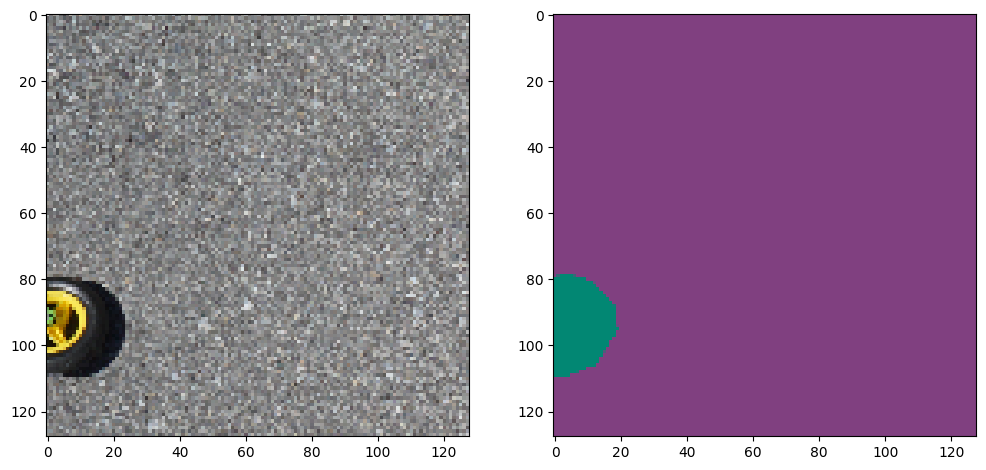

In [ ]:
image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_mask_dataset[image_number])
plt.show()

In [ ]:
mask_labels = pd.read_csv('/content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv')

In [ ]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Dropping the other channels
    return label_seg

In [ ]:
patched_labels = []
for i in tqdm(range(patched_mask_dataset.shape[0])):
    patched_label = rgb_to_labels(patched_mask_dataset[i], mask_labels)
    patched_labels.append(patched_label)

100%|██████████| 1920/1920 [00:34<00:00, 55.87it/s]


In [ ]:
patched_labels = np.array(patched_labels)
patched_labels = np.expand_dims(patched_labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


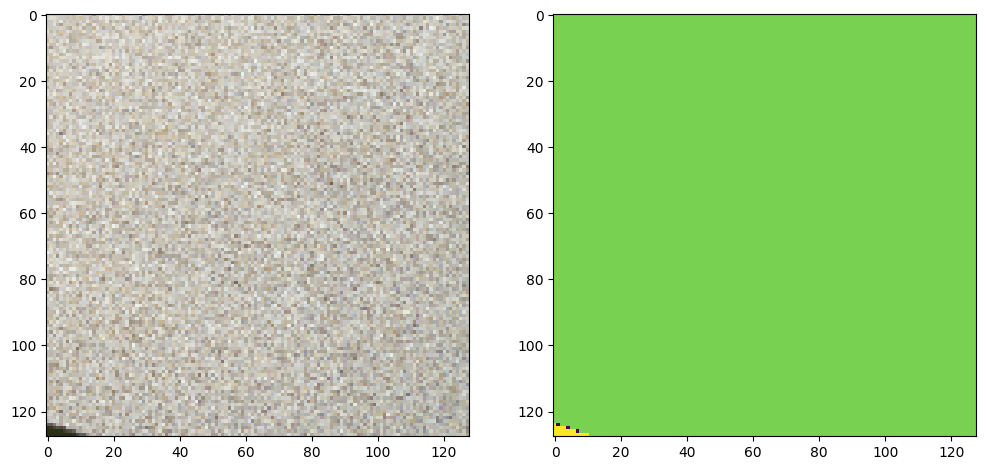

In [ ]:
print("Unique labels in label dataset are: ", np.unique(patched_labels))

image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_labels[image_number][:,:,0])
plt.show()

In [ ]:
n_classes = len(np.unique(patched_labels))
patched_labels_cat = to_categorical(patched_labels, num_classes=n_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(patched_image_dataset, patched_labels_cat, test_size = 0.20, random_state = 42)

##**3.Modelling**


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [ ]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
metrics=['accuracy']
opt = Adam(learning_rate = 0.002)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model_resnet_backbone.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, None, None, 3)  │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, None, None, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, None, None, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, None, None, 64) │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, None, None, 64) │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, None, None, 64) │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, None, None, 64) │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, None, None, 64) │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, None, None, 64) │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, None, None, 64) │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 24,459,344 (93.30 MB)

 Trainable params: 24,441,994 (93.24 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
checkpoint = ModelCheckpoint(filepath="../models/patched_resnet_backbone.h5", verbose=2, save_best_only=True)


early_stop = EarlyStopping(monitor="accuracy", min_delta=0, patience=5)

callbacks = [checkpoint, early_stop]

In [ ]:
history1 = model_resnet_backbone.fit(X_train_prepr,
          y_train,
          batch_size=32,
          epochs=100,
          callbacks=callbacks,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3686 - loss: 2.2751
Epoch 1: val_loss improved from inf to 260978.48438, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.3716 - loss: 2.2646 - val_accuracy: 0.3374 - val_loss: 260978.4844
Epoch 2/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6339 - loss: 1.2959
Epoch 2: val_loss did not improve from 260978.48438
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6342 - loss: 1.2945 - val_accuracy: 0.0614 - val_loss: 1020714.3125
Epoch 3/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6636 - loss: 1.1500
Epoch 3: val_loss improved from 260978.48438 to 13990.52637, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6638 - loss: 1.1494 - val_accuracy: 0.0641 - val_loss: 13990.5264
Epoch 4/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6911 - loss: 1.0844
Epoch 4: val_loss improved from 13990.52637 to 4.93637, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6912 - loss: 1.0845 - val_accuracy: 0.0971 - val_loss: 4.9364
Epoch 5/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6931 - loss: 1.0775
Epoch 5: val_loss did not improve from 4.93637
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6928 - loss: 1.0782 - val_accuracy: 0.2122 - val_loss: 5.4200
Epoch 6/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7102 - loss: 1.0090
Epoch 6: val_loss improved from 4.93637 to 1.51724, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7098 - loss: 1.0105 - val_accuracy: 0.5510 - val_loss: 1.5172
Epoch 7/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7061 - loss: 1.0106
Epoch 7: val_loss improved from 1.51724 to 1.34777, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7065 - loss: 1.0094 - val_accuracy: 0.6393 - val_loss: 1.3478
Epoch 8/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7267 - loss: 0.9360
Epoch 8: val_loss did not improve from 1.34777
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7268 - loss: 0.9358 - val_accuracy: 0.6765 - val_loss: 1.6376
Epoch 9/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7209 - loss: 0.9694
Epoch 9: val_loss improved from 1.34777 to 0.82091, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7208 - loss: 0.9695 - val_accuracy: 0.7569 - val_loss: 0.8209
Epoch 10/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7281 - loss: 0.9574
Epoch 10: val_loss did not improve from 0.82091
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7280 - loss: 0.9566 - val_accuracy: 0.7221 - val_loss: 0.9505
Epoch 11/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7406 - loss: 0.9065
Epoch 11: val_loss did not improve from 0.82091
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7408 - loss: 0.9054 - val_accuracy: 0.7433 - val_loss: 1.0676
Epoch 12/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7521 - loss: 0.8437
Epoch 12: val_loss improved from 0.82091 to 0.76612, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7519 - loss: 0.8444 - val_accuracy: 0.7714 - val_loss: 0.7661
Epoch 13/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7522 - loss: 0.8414
Epoch 13: val_loss did not improve from 0.76612
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7520 - loss: 0.8422 - val_accuracy: 0.7463 - val_loss: 0.8170
Epoch 14/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7480 - loss: 0.8619
Epoch 14: val_loss did not improve from 0.76612
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7480 - loss: 0.8617 - val_accuracy: 0.7439 - val_loss: 0.9508
Epoch 15/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7574 - loss: 0.8244
Epoch 15: val_loss did not improve from 0.76612
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7572 - loss: 0.8254 - val_accuracy: 0.6741 - val_loss: 1.0395
Epoch 16/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7663 - loss: 0.7921
Epoch 16: val_loss improved from 0.76612 to 

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7661 - loss: 0.7926 - val_accuracy: 0.7676 - val_loss: 0.7489
Epoch 17/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7602 - loss: 0.7946
Epoch 17: val_loss did not improve from 0.74894
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7604 - loss: 0.7947 - val_accuracy: 0.7177 - val_loss: 0.9275
Epoch 18/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7759 - loss: 0.7702
Epoch 18: val_loss did not improve from 0.74894
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7757 - loss: 0.7705 - val_accuracy: 0.7670 - val_loss: 0.8206
Epoch 19/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7644 - loss: 0.7972
Epoch 19: val_loss did not improve from 0.74894
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7645 - loss: 0.7969 - val_accuracy: 0.5545 - val_loss: 1.8761
Epoch 20/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7679 - loss: 0.7853
Epoch 20: val_loss did not improve from 0.74

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8041 - loss: 0.6635 - val_accuracy: 0.7776 - val_loss: 0.7242
Epoch 26/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7917 - loss: 0.6913
Epoch 26: val_loss improved from 0.72418 to 0.66340, saving model to ../models/patched_resnet_backbone.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7917 - loss: 0.6916 - val_accuracy: 0.8068 - val_loss: 0.6634
Epoch 27/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8055 - loss: 0.6507
Epoch 27: val_loss did not improve from 0.66340
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8049 - loss: 0.6530 - val_accuracy: 0.7242 - val_loss: 0.9674
Epoch 28/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7847 - loss: 0.7097
Epoch 28: val_loss did not improve from 0.66340
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7850 - loss: 0.7092 - val_accuracy: 0.7735 - val_loss: 0.7304
Epoch 29/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7945 - loss: 0.6989
Epoch 29: val_loss did not improve from 0.66340
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7946 - loss: 0.6986 - val_accuracy: 0.7889 - val_loss: 0.7257
Epoch 30/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8210 - loss: 0.6080
Epoch 30: val_loss did not improve from 0.66

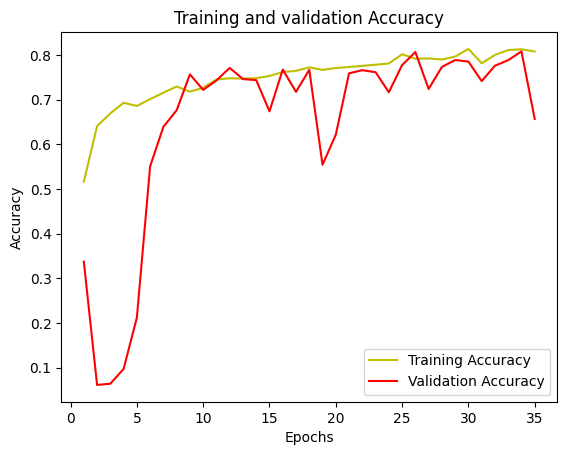

In [ ]:

history = history1
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
patched_model = load_model('../models/patched_resnet_backbone.h5')

##**4.Predictions and Visualization**

In [ ]:
y_pred=patched_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


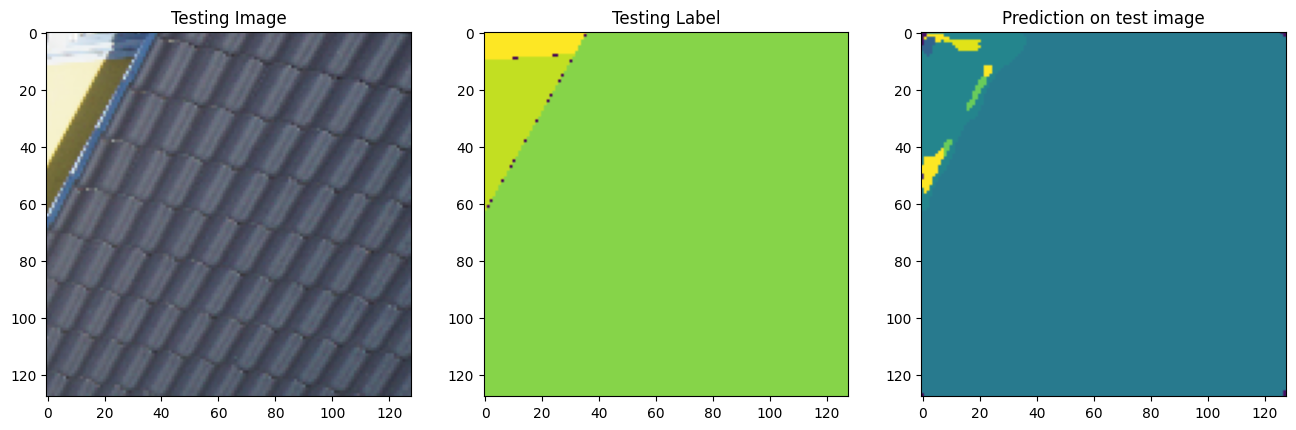

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (patched_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()